# Unaccompanied Migrant Children Machine Learning Model

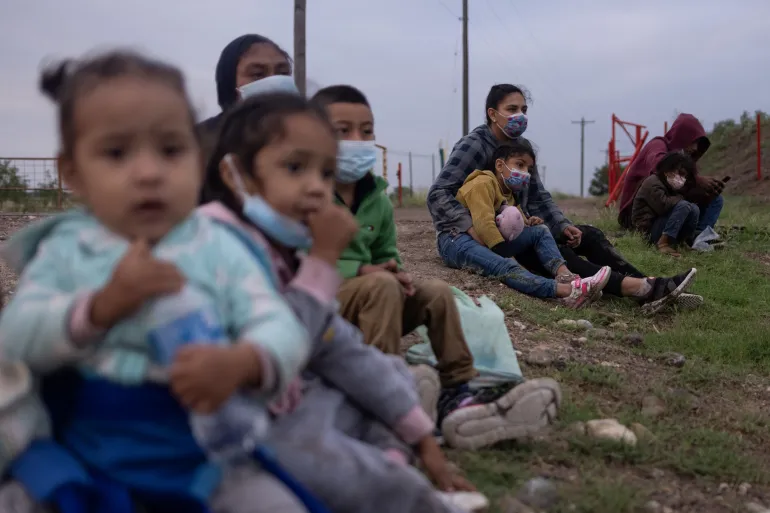

_[Fig. 1](https://www.aljazeera.com/news/2021/5/22/migrant-children-in-us-the-cards-are-stacked-against-them): Migrant children waiting for transportation to the U.S. border in Central America with their families._


The United States is a popular destination for many immigrants, and this is no exception for children who may be **making the journey by themselves.** They may have been <u>forced out</u> by war or unrest in their native countries, or they may have left <u>voluntarily</u> to seek better opportunities. In either case, **unaccompanied child migrants** are often detained by the **Office of Refugee Settlement** by the U.S.-Mexico border. For a child migrant to leave, a family member must **sponsor** their release.

The [New York Times](https://github.com/nytimes/hhs-child-migrant-data) has released data on unaccompanied child migrants from the **U.S. Department of Human Health and Services.** A machine learning model has been created to predict what makes a child more likely to **stay detained for a month or longer.** What might prevent a family member from getting to their child?

## Dataset information

The original dataset:

| Column | Meaning |
|:---:|:---:|
| ID | Unique number to identify the child |
| Child's Country of Origin | The country the child came from |
| Child's Gender | Typically by their assigned sex: M or F |
| Child's Date of Entry | The day the child got detained |
| Child's Date of Release | The day the child's sponsor released them |
| Sponsor Zipcode | Zipcode of the sponsor's residence |
| Sponsor Category | How close the sponsor is to the child (1-3) |
| Relationship of Sponsor | How the sponsor is related to the child |

_Sponsor Category:_  
  1) Parent or legal guardian (closest)  
  2) Immediate relative (ex. aunt, uncle)  
  3) Distant relative, or unrelated adult individual


From the data cleaning and exploratory data analysis below, the final dataset will look like this:

| Column | Meaning |
|:---:|:---:|
| id | Unique number to identify the child |
| gender | Typically by their assigned sex: M or F |
| sponsor_code | How close the sponsor is to the child (1-3) |
| detained_for_month | Whether the child was detained for a month or longer |
| year | The year the child was detained |
| distance_code | Child's distance from the USA (0-4) |

## Import and load packages

In [27]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *

# Save models after fitting
import pickle

# Filter out certain warnings; useful for columns to be deleted
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load dataset, all rows
df = pd.read_csv("data.csv")
pd.set_option('display.max_rows', None)

# Display first few rows of dataframe
df.head()

,ID,Child's Country of Origin,Child's Gender,Child's Date of Entry,Child's Date of Release,Sponsor Zipcode,Sponsor Category,Relationship of Sponsor
0,1,Honduras,F,1/1/15,1/28/15,37863,1.0,Mother
1,2,Honduras,F,1/1/15,1/23/15,28212,1.0,Mother
2,3,Honduras,F,1/1/15,1/23/15,28212,2.0,Aunt
3,4,Honduras,M,1/2/15,1/30/15,27501,2.0,Brother
4,5,Honduras,M,1/1/15,2/13/15,78747,3.0,Other Cousin


## Exploratory data analysis and cleaning

In [29]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         553322 non-null  int64  
 1   Child's Country of Origin  553322 non-null  object 
 2   Child's Gender             553322 non-null  object 
 3   Child's Date of Entry      553322 non-null  object 
 4   Child's Date of Release    553322 non-null  object 
 5   Sponsor Zipcode            553310 non-null  object 
 6   Sponsor Category           552666 non-null  float64
 7   Relationship of Sponsor    553322 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.8+ MB


In [30]:
# Change the child dates of entry and release to datetime type
df['Child\'s Date of Entry'] = pd.to_datetime(df['Child\'s Date of Entry'])
df['Child\'s Date of Release'] = pd.to_datetime(df['Child\'s Date of Release'])

# Confirm that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         553322 non-null  int64         
 1   Child's Country of Origin  553322 non-null  object        
 2   Child's Gender             553322 non-null  object        
 3   Child's Date of Entry      553322 non-null  datetime64[ns]
 4   Child's Date of Release    553322 non-null  datetime64[ns]
 5   Sponsor Zipcode            553310 non-null  object        
 6   Sponsor Category           552666 non-null  float64       
 7   Relationship of Sponsor    553322 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 33.8+ MB


In [31]:
# Convert column names to snake_case and shorter names
df = df.rename(columns = {
    'ID': 'id',
    'Child\'s Country of Origin': 'country',
    'Child\'s Gender': 'gender',
    'Child\'s Date of Entry': 'entry_date',
    'Child\'s Date of Release': 'release_date',
    'Sponsor Zipcode': 'sponsor_zipcode',
    'Sponsor Category': 'sponsor_code',
    'Relationship of Sponsor': 'relationship_of_sponsor'
})

# Display all column names
df.columns

Index(['id', 'country', 'gender', 'entry_date', 'release_date',
       'sponsor_zipcode', 'sponsor_code', 'relationship_of_sponsor'],
      dtype='object')

In [32]:
# Create a days detained column by subtracting the entry date from the release date
df['days_detained'] = (df['release_date'] - df['entry_date']).dt.days

# Make this column by assigning 0 if a child spent less than 30 days detained, and 1 otherwise
df['detained_for_month'] = np.where(df['days_detained'] >= 30, 1, 0)

# Get the year the child was detained in the 'year' column
df['year'] = df['entry_date'].dt.year

# Display first few rows of dataframe
df.head()

,id,country,gender,entry_date,release_date,sponsor_zipcode,sponsor_code,relationship_of_sponsor,days_detained,detained_for_month,year
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother,27,0,2015
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother,22,0,2015
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt,22,0,2015
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother,28,0,2015
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin,43,1,2015


Make column to identify place by continent rather than country, for convenience

In [7]:
# Install pycountry
!pip install pycountry-convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 16.5 MB/s eta 0:00:00


In [33]:
# Import continent library
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code, convert_continent_code_to_continent_name

# Function to get the continent from the country using the libraries above
def get_continent(row):
    try:
        country_code = country_name_to_country_alpha2(row)
        continent_code = country_alpha2_to_continent_code(country_code)
        continent_name = convert_continent_code_to_continent_name(continent_code)

        return continent_name
    except:
        return 'N/A'

df['continent'] = df['country'].apply(get_continent)

# See how it looks
df.head()

,id,country,gender,entry_date,release_date,sponsor_zipcode,sponsor_code,relationship_of_sponsor,days_detained,detained_for_month,year,continent
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother,27,0,2015,North America
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother,22,0,2015,North America
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt,22,0,2015,North America
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother,28,0,2015,North America
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin,43,1,2015,North America


In [34]:
# GROUP CONTINENTS BY DISTANCE.
# CLOSEST TO FARTHEST: North America (0), South America (1), Europe (2), Africa(3), Asia(4)

def get_distance(row):
    if row == 'North America':
        return 0
    elif row == 'South America':
        return 1
    elif row == 'Europe':
        return 2
    elif row == 'Africa':
        return 3
    elif row == 'Asia':
        return 4
    return -1

df['distance_code'] = df['continent'].apply(get_distance)

# See how it looks
df.head()

,id,country,gender,entry_date,release_date,sponsor_zipcode,sponsor_code,relationship_of_sponsor,days_detained,detained_for_month,year,continent,distance_code
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother,27,0,2015,North America,0
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother,22,0,2015,North America,0
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt,22,0,2015,North America,0
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother,28,0,2015,North America,0
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin,43,1,2015,North America,0


In [74]:
# Delete columns that are no longer needed, only keep those needed for data visualization and model fitting
del df['country']
del df['sponsor_zipcode']
del df['entry_date']
del df['release_date']
del df['relationship_of_sponsor']
del df['days_detained']
del df['continent']

# View cleaned dataset
df.head()

,id,gender,sponsor_code,detained_for_month,year,distance_code
0,1,F,1.0,0,2015,0
1,2,F,1.0,0,2015,0
2,3,F,2.0,0,2015,0
3,4,M,2.0,0,2015,0
4,5,M,3.0,1,2015,0


In [36]:
# View the complete basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  553322 non-null  int64  
 1   gender              553322 non-null  object 
 2   sponsor_code        552666 non-null  float64
 3   days_detained       553322 non-null  int64  
 4   detained_for_month  553322 non-null  int64  
 5   year                553322 non-null  int32  
 6   distance_code       553322 non-null  int64  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 27.4+ MB


In [37]:
# Gather descriptive statistics about the data
df.describe()

,id,sponsor_code,days_detained,detained_for_month,year,distance_code
count,553322.000000,552666.000000,553322.000000,553322.000000,553322.000000,553322.000000
mean,276659.510289,1.697588,36.715811,0.409169,2019.666934,0.076643
std,159730.429443,0.664395,38.717129,0.491681,2.483040,0.459770
min,1.000000,1.000000,0.000000,0.000000,2015.000000,-1.000000
25%,138329.250000,1.000000,16.000000,0.000000,2018.000000,0.000000
50%,276659.500000,2.000000,25.000000,0.000000,2021.000000,0.000000
75%,414989.750000,2.000000,43.000000,1.000000,2022.000000,0.000000
max,553320.000000,3.000000,1747.000000,1.000000,2023.000000,4.000000


### Check for missing values

In [38]:
# Check missing values
df.isna().sum()

,0
id,0
gender,0
sponsor_code,656
days_detained,0
detained_for_month,0
year,0
distance_code,0


In [39]:
# Investigate missing values
df[df['sponsor_code'].isna()].head()

,id,gender,sponsor_code,days_detained,detained_for_month,year,distance_code
10,11,M,NaN,24,0,2015,0
13,14,M,NaN,35,1,2015,0
17,18,M,NaN,36,1,2015,0
18,19,M,NaN,15,0,2015,0
23,24,M,NaN,40,1,2015,0


In [40]:
# Delete missing values
df = df.dropna()

# Check that it worked
df.isna().sum()

,0
id,0
gender,0
sponsor_code,0
days_detained,0
detained_for_month,0
year,0
distance_code,0


### Check duplicates

In [41]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# Investigate the rows with duplicates
df[df.duplicated()]

,id,gender,sponsor_code,detained_for_month,year,distance_code
1905,1905,M,2.0,0,2015,0
3788,3787,M,2.0,1,2015,0


**Different IDs indicate different people, moving on.**

## Data visualizations

In [42]:
# Drop 'nan' in sponsor_code
df = df[df['sponsor_code'] != 'nan']

# Check that it worked
df['sponsor_code'].value_counts()

,count
sponsor_code,
2.0,258165
1.0,230817
3.0,63684


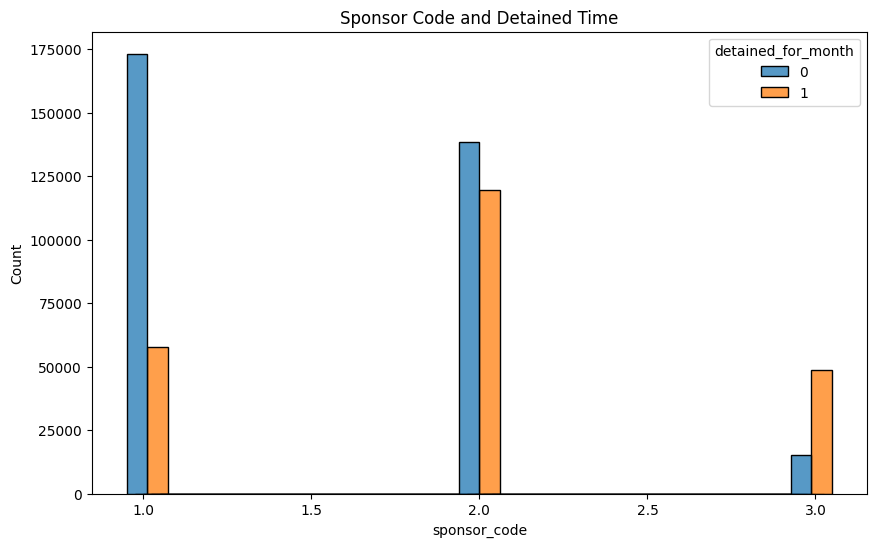

In [44]:
# Boxplot of sponsor code and count, with detained_for_month as the hue
plt.figure(figsize = (10, 6))
sponsor_long = df[df['detained_for_month'] == 0]['sponsor_code']
sponsor_quick = df[df['detained_for_month'] == 1]['sponsor_code']
sns.histplot(data = df, x = 'sponsor_code', hue = 'detained_for_month', multiple = 'dodge', shrink = 5)
plt.title('Sponsor Code and Detained Time')
plt.show()

In [45]:
# Get percentages of the children count per sponsor code in respect to detained_for_month
df.groupby('sponsor_code')['detained_for_month'].value_counts(normalize = True)

sponsor_code  detained_for_month
1.0           0                     0.750434
              1                     0.249566
2.0           0                     0.536703
              1                     0.463297
3.0           1                     0.764399
              0                     0.235601
Name: proportion, dtype: float64

Shorter detainment periods are more likely for parents or legal guardians with a 75% rate. Meanwhile, longer detainment periods are likely for more distant relationships, with 54% for 2.0 and 76% for 3.0.

In [46]:
# Delete -1 in distance code
df = df[df['distance_code'] != -1]

# Check that it worked
df['distance_code'].value_counts()

,count
distance_code,
0,530247
1,15134
4,6102
2,703
3,448


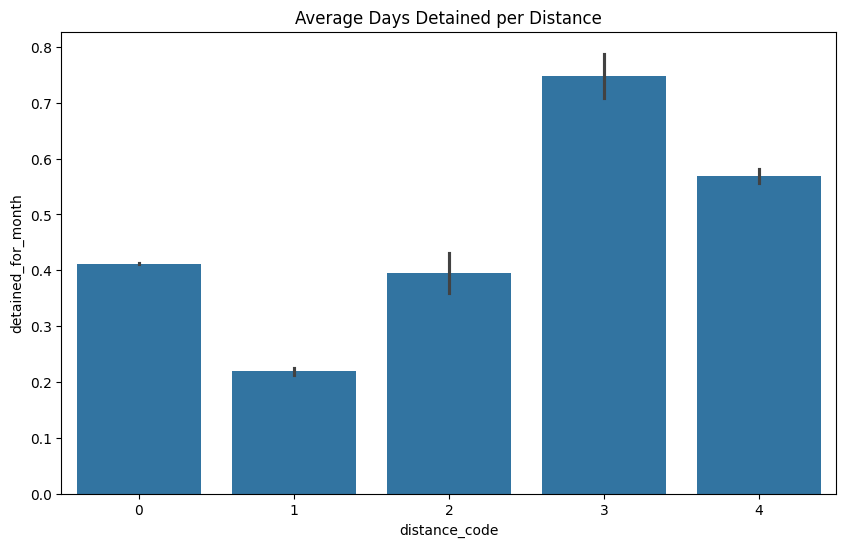

In [47]:
# Bar graph of average days detained per distance
plt.figure(figsize = (10, 6))
sns.barplot(data = df, x = 'distance_code', y = 'detained_for_month')
plt.title('Average Days Detained per Distance')
plt.show()

**96% of released detained children came from North America, the same as the U.S.**

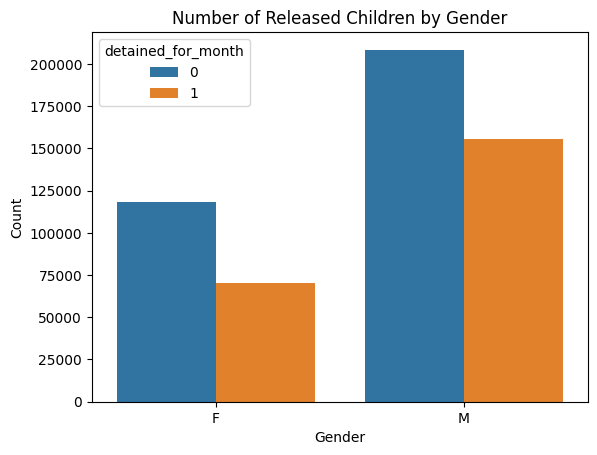

In [48]:
# Make a bar plot counting the number of children per gender, with detained_for_month as the hue
sns.countplot(x = 'gender', hue = 'detained_for_month', data = df)
plt.title('Number of Released Children by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Gender does not seem to make a difference when it comes to how long a child stays detained for. The height differences just indicate how many children identify with that gender.

In [49]:
# Get percentages of children count per gender, with respect to detained_for_month
df.groupby('gender')['detained_for_month'].value_counts(normalize = True)

gender  detained_for_month
F       0                     0.627342
        1                     0.372658
M       0                     0.572582
        1                     0.427418
Name: proportion, dtype: float64

37% of females face long detainment periods, while males face 43%, which is not a huge difference.

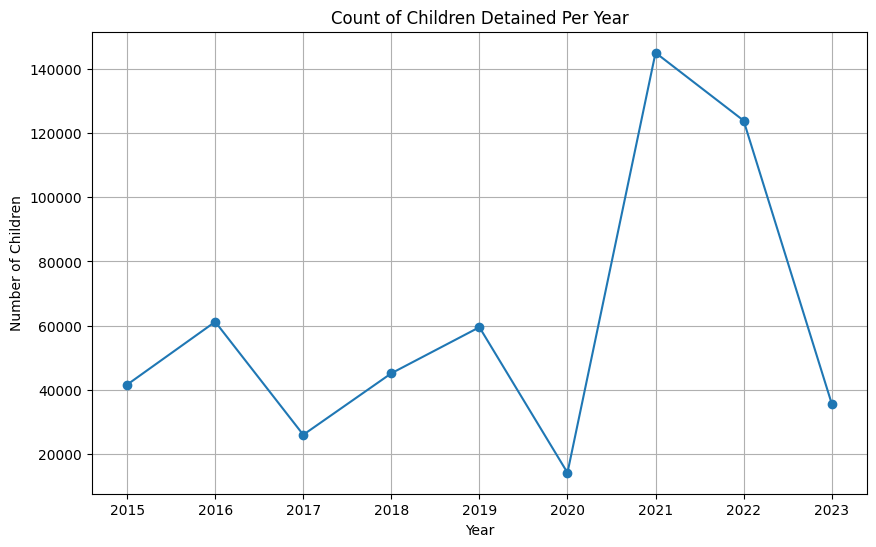

In [50]:
# Make a lineplot of the count of children per year
plt.figure(figsize=(10, 6))
df.groupby('year').size().plot(kind='line', marker='o')
plt.title('Count of Children Detained Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Children')
plt.grid(True)
plt.show()

In [25]:
# Get the percentage increase from 2020 to 2021 in number of children
(df[df['year'] == 2021].shape[0] - df[df['year'] == 2020].shape[0]) / df[df['year'] == 2020].shape[0]

9.157020739910314

**Insights**
- Children are 75% more likely to get released earlier if a parent or legal guardian sponsors their release.
- 96% of unaccompanied migrant children come from North America, the same continent as the U.S.
- Gender does not determine how long a child stays in custody: 37% of females and 42% of males face long detainment times.
- A spike in unaccompanied children enters the U.S. is observed during the pandemic and Joe Biden's presidency, peaking in 2021: over a 900% increase.

## Model Building

In [57]:
# Copy columns to be encoded
df_enc = df[['gender', 'sponsor_code', 'detained_for_month', 'distance_code']].copy()

# Encode the 'gender' column via dummy variables
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display first few rows of dataframe
df_enc.head()

,sponsor_code,detained_for_month,distance_code,gender_F,gender_M
0,1.0,0,0,True,False
1,1.0,0,0,True,False
2,2.0,0,0,True,False
3,2.0,0,0,False,True
4,3.0,1,0,False,True


In [58]:
# Isolate the outcome variable
y = df_enc['detained_for_month']

# Display the first few rows of y
y.head()

,detained_for_month
0,0
1,0
2,0
3,0
4,1


In [59]:
# Select the features
X = df_enc.drop(columns = ['detained_for_month'])

# Display the first few rows of X
X.head()

,sponsor_code,distance_code,gender_F,gender_M
0,1.0,0,True,False
1,1.0,0,True,False
2,2.0,0,True,False
3,2.0,0,False,True
4,3.0,0,False,True


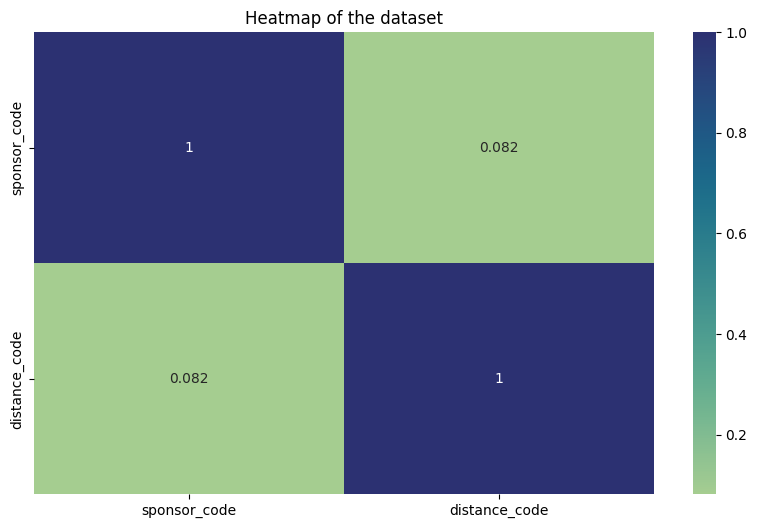

In [62]:
# Heatmap of encoded dataset
plt.figure(figsize=(10,6))
sns.heatmap(df_enc[['sponsor_code', 'distance_code']].corr(), annot=True, cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 0)

In [64]:
# Instantiate model
tree = DecisionTreeClassifier(random_state = 0)

# Dictionary of hyperparameters to search over
cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
  }

# Dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [65]:
# Fit the tree
%%time
tree1.fit(X_train, y_train)

CPU times: user 20.5 s, sys: 51.2 ms, total: 20.5 s
Wall time: 20.6 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [66]:
# Find the best parameters
tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [67]:
# Find the best AUC score on the CV
tree1.best_score_

np.float64(0.6797689874298275)

In [68]:
# DISCLAIMER: THIS FUNCTION IS INSPIRED BY THE GOOGLE ADVANCED DATA ANALYTICS CERTIFICATE.

# Pre-defined function to get the metrics from the model
def results(model_name:str, model_object, metric:str):

  # Dictionary of mean metrics
  metric_dict = {
      'accuracy': 'mean_test_accuracy',
      'precision': 'mean_test_precision',
      'recall': 'mean_test_recall',
      'f1': 'mean_test_f1',
      'auc': 'mean_test_roc_auc'
  }

  # Get the row with the best results
  cv_results = pd.DataFrame(model_object.cv_results_)
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract the metrics from the best row
  accuracy = best_estimator_results['mean_test_accuracy']
  precision = best_estimator_results['mean_test_precision']
  recall = best_estimator_results['mean_test_recall']
  f1 = best_estimator_results['mean_test_f1']
  auc = best_estimator_results['mean_test_roc_auc']

  # Put the best results in a table
  results = pd.DataFrame({
      'Model': [model_name],
      'Accuracy': [accuracy],
      'Precision': [precision],
      'Recall': [recall],
      'F1': [f1],
      'AUC': [auc]
  })
  return results

In [69]:
results('Decision Tree', tree1, 'auc')

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree,0.652165,0.763691,0.21572,0.336406,0.679769


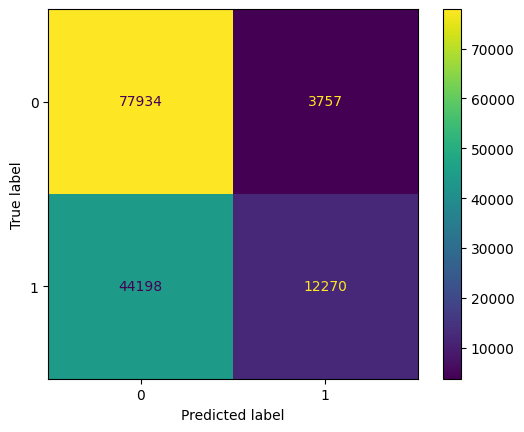

In [70]:
# Confusion matrix
y_pred = tree1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tree1.classes_)
display.plot()
plt.show()

_Positive: Detained for 1 month, negative = less than a month_
- **True negative**: 77934
- False negative: 44198
- False positive: 3757
- **True positive**: 12270

**~65% of predictions are accurate.**

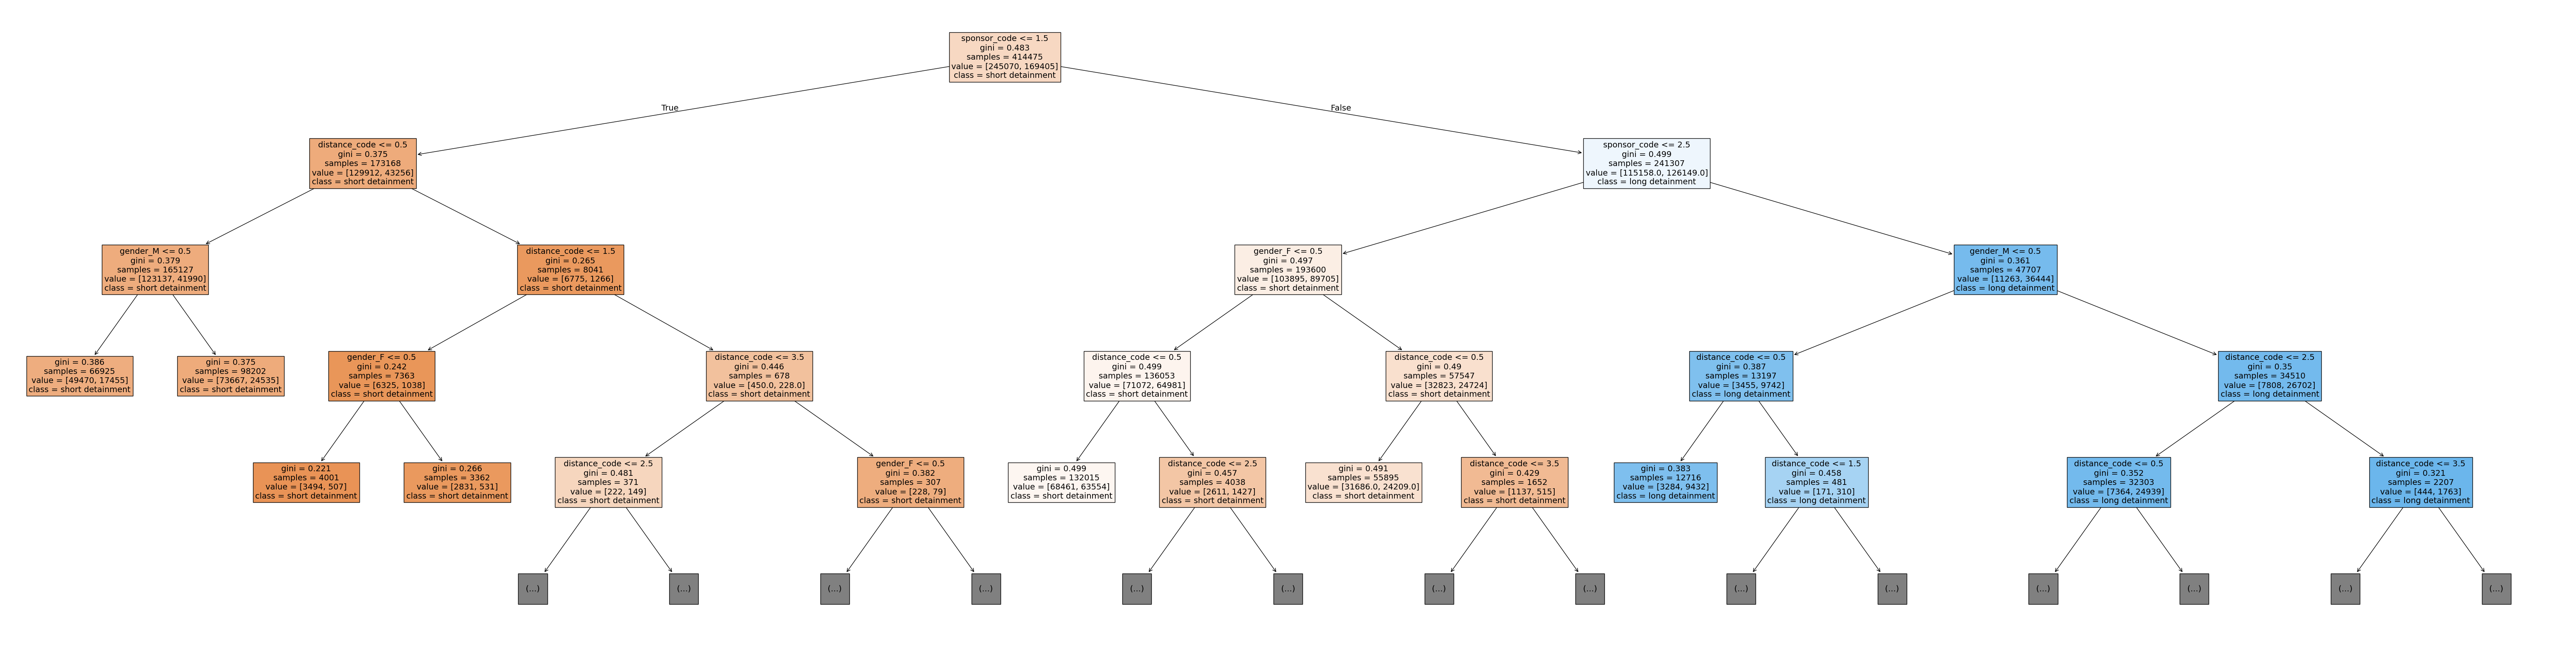

In [71]:
# Decision tree splits
plt.figure(figsize = (80, 20))
plot_tree(tree1.best_estimator_, max_depth = 4, feature_names = X.columns,
          class_names = {0: 'short detainment', 1: 'long detainment'}, filled = True, fontsize = 14)
plt.show()

In [72]:
# Gini importance
tree1_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_,
                                 columns = ['gini_importance'],
                                 index = X.columns)

tree1_importances.sort_values(by = 'gini_importance', ascending = False)

# Features with importances > 0
tree1_importances = tree1_importances[tree1_importances['gini_importance'] > 0]
tree1_importances

,gini_importance
sponsor_code,0.968282
distance_code,0.021834
gender_F,0.008376
gender_M,0.001508


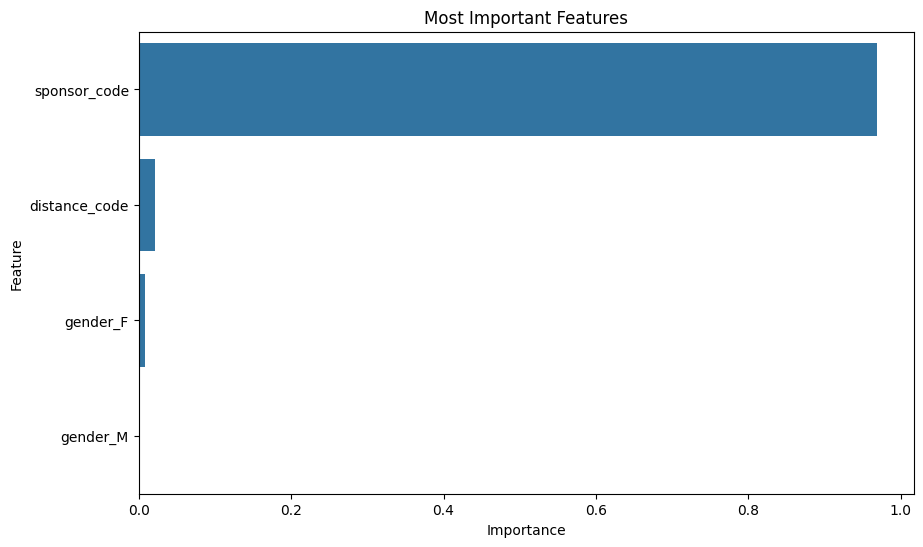

In [73]:
# Bar chart to visualize the most important features as determined above
plt.figure(figsize = (10, 6))
sns.barplot(data = tree1_importances, x = 'gini_importance', y = tree1_importances.index, orient = 'h')
plt.title('Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Results
This machine-learning model confirms what was already reflected in the first Tableau dashboard completed in February 2025: **Distant family members contribute to more time spent detained, with a 97% importance rate.** Less detainment time is likely if a parent or legal guardian sponsors their release. That's why it's crucial to **develop close bonds with one's children.**

For a more accurate model, we may consider trying different models for comparison, like a linear regression model. Such models may make features like `distance_code` play a bigger role than what was demonstrated here.

As for the model itself, **data leakage is still a concern.** Either metric may dramatically increase or decrease with future tests. This all depends on the processing power of the computer being used. In this case, more tests and model building may be necessary.